# Prepare Dataset

In [2]:
import pandas as pd
import numpy as np

In [3]:
config = {
    'companies': ['A'],
    'seq_len': 50
}

In [4]:
# stock dataframe
df_stocks = pd.read_csv("s3://financial-analysis-project-bucket/SageMaker/stocks.csv", encoding='utf-16')
df_stocks = df_stocks.drop(['Adj Close', 'Volume'], axis=1)

df_news = pd.read_csv("s3://financial-analysis-project-bucket/SageMaker/news_sentiment.csv")
# sentiment grouped by date and company
# sentiment determined by the mode
df_grouped = df_news.groupby(['date', 'symbol']).agg(sentiment=('sentiment', pd.Series.mode)).reset_index()

df_grouped = df_grouped.rename(columns={'date': 'Date', 'symbol': 'Ticker', 'sentiment': 'Sentiment'})

In [5]:
# if more than 1 mode, choose appropriate sentiment

sentiment_mapping = {
    ('negative', 'neutral', 'positive'): 'neutral',
    ('negative', 'neutral'): 'negative',
    ('negative', 'positive'): 'neutral',
    ('neutral', 'positive'): 'positive'
}

df_grouped['Sentiment'] = df_grouped['Sentiment'].map(lambda x: sentiment_mapping[tuple(x.tolist())] if type(x) == np.ndarray else x)

In [6]:
# join stocks and news sentiment on date
df_join = df_stocks.merge(df_grouped, on=['Date', 'Ticker'], how='left').set_index('Date')
df_join.index = pd.to_datetime(df_join.index)

In [7]:
# filter for specific company
df = df_join[df_join['Ticker'].isin(config['companies'])]
# sentiment is neutral if no sentiment
df = df.fillna('neutral')
print(df)
print(df['Sentiment'].value_counts())

           Ticker       Close        High         Low        Open Sentiment
Date                                                                       
2009-01-02      A   10.363297   10.401585    9.897459    9.954891   neutral
2009-01-05      A   10.714271   10.905712   10.210145   10.286721   neutral
2009-01-06      A   11.569368   11.939486   10.778083   10.912091   neutral
2009-01-07      A   11.633182   11.779953   11.288590   11.390690   neutral
2009-01-08      A   11.709760   11.792718   11.358787   11.588515   neutral
...           ...         ...         ...         ...         ...       ...
2024-12-23      A  134.066849  134.156489  132.642505  133.628589   neutral
2024-12-24      A  135.560898  135.560898  133.618610  134.066840   neutral
2024-12-26      A  135.291977  135.441377  134.435383  134.475218   neutral
2024-12-27      A  135.003113  135.680427  134.056879  134.086759   neutral
2024-12-30      A  133.887543  135.052906  132.712224  133.867618   neutral

[4025 rows 

In [8]:
from sklearn.preprocessing import OrdinalEncoder

# encode company and sentiment to numeric
categorical_columns = ['Ticker', 'Sentiment']
enc = OrdinalEncoder()
df[categorical_columns] = enc.fit_transform(df[categorical_columns])
print(enc.categories_)
df

[array(['A'], dtype=object), array(['negative', 'neutral', 'positive'], dtype=object)]


,Ticker,Close,High,Low,Open,Sentiment
Date,,,,,,
2009-01-02,0.0,10.363297,10.401585,9.897459,9.954891,1.0
2009-01-05,0.0,10.714271,10.905712,10.210145,10.286721,1.0
2009-01-06,0.0,11.569368,11.939486,10.778083,10.912091,1.0
2009-01-07,0.0,11.633182,11.779953,11.288590,11.390690,1.0
2009-01-08,0.0,11.709760,11.792718,11.358787,11.588515,1.0
...,...,...,...,...,...,...
2024-12-23,0.0,134.066849,134.156489,132.642505,133.628589,1.0
2024-12-24,0.0,135.560898,135.560898,133.618610,134.066840,1.0
2024-12-26,0.0,135.291977,135.441377,134.435383,134.475218,1.0


In [9]:
company_mapping = {}
for i in range(len(enc.categories_[0])):
    company_mapping[enc.categories_[0][i]] = i
company_mapping

{'A': 0}

In [10]:
# split dataframe into indiviudal df based on company
df_dict = {}
for company, encoding in company_mapping.items():
    df_dict[company] = df[df['Ticker'] == encoding]

In [11]:
# split dataframe into train and test
def train_test_split(df):
    training_size = int(len(df) * 0.8)
    train = df[:training_size]
    test = df[training_size:]
    assert(len(train) + len(test) == len(df))
    return train, test

# further divide each company's df into train and test
for company, df in df_dict.items():
    train, test = train_test_split(df)
    df_dict[company] = {'train': train, 'test': test}

In [12]:
df_dict

{'A': {'train':             Ticker       Close        High         Low        Open  Sentiment
  Date                                                                         
  2009-01-02     0.0   10.363297   10.401585    9.897459    9.954891        1.0
  2009-01-05     0.0   10.714271   10.905712   10.210145   10.286721        1.0
  2009-01-06     0.0   11.569368   11.939486   10.778083   10.912091        1.0
  2009-01-07     0.0   11.633182   11.779953   11.288590   11.390690        1.0
  2009-01-08     0.0   11.709760   11.792718   11.358787   11.588515        1.0
  ...            ...         ...         ...         ...         ...        ...
  2021-10-11     0.0  146.440292  148.724453  146.303634  147.875217        1.0
  2021-10-12     0.0  144.419693  147.572616  142.809070  147.572616        1.0
  2021-10-13     0.0  146.635544  147.279799  145.190863  145.522746        1.0
  2021-10-14     0.0  148.948975  149.817737  148.002119  148.002119        1.0
  2021-10-15     0.0  149.

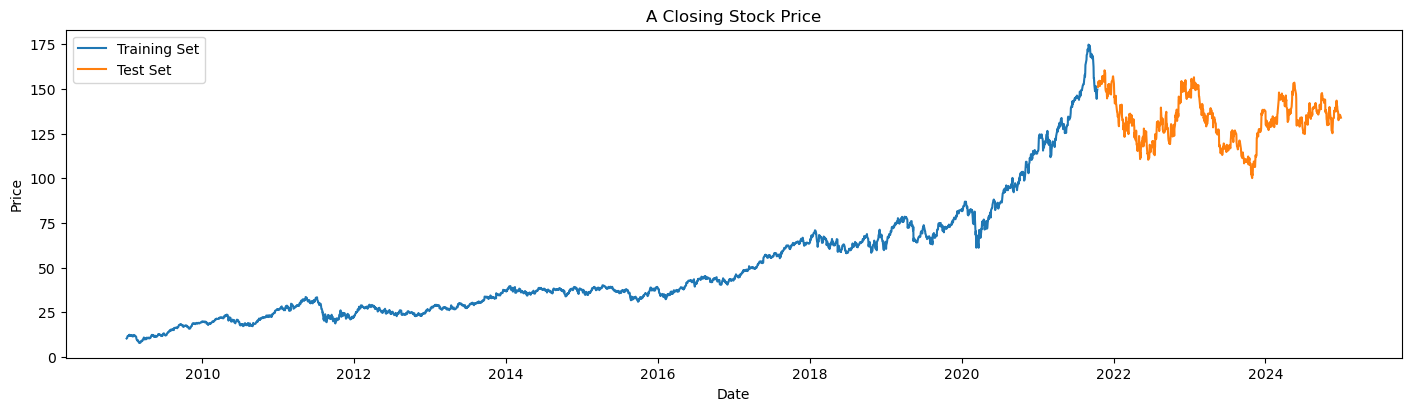

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

fig, axs = plt.subplots(len(df_dict), figsize=(14, 4 * len(df_dict)), constrained_layout=True)

# Ensure axs is always iterable
if len(df_dict) == 1:
    axs = [axs]
    
for i, company in enumerate(df_dict):
    axs[i].plot(df_dict[company]['train'].index, df_dict[company]['train']['Close'])
    axs[i].plot(df_dict[company]['test'].index, df_dict[company]['test']['Close'])
    axs[i].set_title(f'{company} Closing Stock Price')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Price')
    axs[i].legend(["Training Set", "Test Set"])

# Deep Learning (LSTM)

In [14]:
from sklearn.preprocessing import MinMaxScaler

# scale numeric columns for each company, as LSTM works better with normalized data
# store the scaler

scaler_dict = {}
df_scaled_dict = {}
numerical_columns = ['Close', 'High', 'Low', 'Open']

for company in df_dict:
    scaler = MinMaxScaler(feature_range=(0,1))
    train = df_dict[company]['train'].copy()
    test = df_dict[company]['test'].copy()
    train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
    test[numerical_columns] = scaler.transform(test[numerical_columns])
    df_scaled_dict[company] = {'train': train, 'test': test}
    scaler_dict[company] = scaler

In [15]:
# use sliding window of size seq_len to create sequential data, where input is seq_len data and output is next day close price
def create_dataset(dataset, seq_len):
    X = []
    y = []
    for i in range(len(dataset) - seq_len):
        X.append(dataset.iloc[i:i + seq_len])
        y.append(dataset.iloc[i + seq_len]['Close'])
    return np.array(X), np.array(y)

In [16]:
X_train_dict, y_train_dict, X_test_dict, y_test_dict = {}, {}, {}, {}
# keep track of size for input output dataset
dataset_shape_df = {'X_train':[], 'y_train':[], 'X_test':[], 'y_test':[]}

# create dataset for train and test for each company
for company in df_scaled_dict:
    X_train, y_train = create_dataset(df_scaled_dict[company]['train'], config['seq_len'])
    X_test, y_test = create_dataset(df_scaled_dict[company]['test'], config['seq_len'])
    X_train_dict[company] = X_train
    y_train_dict[company] = y_train
    X_test_dict[company] = X_test
    y_test_dict[company] = y_test
    dataset_shape_df['X_train'].append(X_train.shape)
    dataset_shape_df['y_train'].append(y_train.shape)
    dataset_shape_df['X_test'].append(X_test.shape)
    dataset_shape_df['y_test'].append(y_test.shape)

pd.DataFrame(dataset_shape_df, index=df_scaled_dict.keys())

,X_train,y_train,X_test,y_test
A,"(3170, 50, 6)","(3170,)","(755, 50, 6)","(755,)"


In [18]:
import sagemaker
import joblib

# save train, test, and scaler
joblib.dump(X_train_dict, "X_train_dict.joblib")
joblib.dump(y_train_dict, "y_train_dict.joblib")
joblib.dump(X_test_dict, "X_test_dict.joblib")
joblib.dump(y_test_dict, "y_test_dict.joblib")
joblib.dump(scaler_dict, "scaler_dict.joblib")

['scaler_dict.joblib']

In [19]:
# upload train, test, and scaler to S3
sess = sagemaker.Session()
bucket_name = 'financial-analysis-project-bucket'
key = 'SageMaker'

xtrain_path = sess.upload_data(
    path="X_train_dict.joblib",
    bucket=bucket_name,
    key_prefix=key,
)
ytrain_path = sess.upload_data(
    path="y_train_dict.joblib",
    bucket=bucket_name,
    key_prefix=key,
)
xtest_path = sess.upload_data(
    path="X_test_dict.joblib",
    bucket=bucket_name,
    key_prefix=key,
)
ytest_path = sess.upload_data(
    path="y_test_dict.joblib",
    bucket=bucket_name,
    key_prefix=key,
)
scaler_path = sess.upload_data(
    path="scaler_dict.joblib",
    bucket=bucket_name,
    key_prefix=key,
)

print(xtrain_path)

s3://financial-analysis-project-bucket/SageMaker/X_train_dict.joblib


In [23]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker import get_execution_role
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
   entry_point="script.py",
   role=get_execution_role(),
   instance_count=1,
   instance_type="ml.m5.xlarge",
   framework_version="2.12",
    py_version='py310',
   base_job_name="lstm",
   hyperparameters={
       "epochs": 10,
       "batch_size": 128,
   },
)

# Launch training job, with asynchronous call
estimator.fit({
    'xtrain': xtrain_path,
    'ytrain': ytrain_path,
    'xtest': xtest_path,
    'ytest': ytest_path,
    'scaler': scaler_path
}, wait=True)

[05/25/25 01:28:12] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=7820;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=738293;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[05/25/25 01:28:13] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=45569;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=578225;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name: lstm-2025-05-25-01-28-12-808          ]8;id=407486;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=782261;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-05-25 01:28:13 Starting - Starting the training job...
2025-05-25 01:28:35 Starting - Preparing the instances for training...
2025-05-25 01:28:55 Downloading - Downloading input data...
2025-05-25 01:29:20 Downloading - Downloading the training image......
2025-05-25 01:30:26 Training - Training image download completed. Training in progress.2025-05-25 01:30:34.524418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-25 01:30:36,861 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2025-05-25 01:30:36,862 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-05-25 01:30:36,863 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2

In [25]:
import boto3
sm_boto3 = boto3.client("sagemaker")
artifact = sm_boto3.describe_training_job(
   TrainingJobName=estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)

Model artifact persisted at s3://sagemaker-us-east-1-207567756516/lstm-2025-05-25-01-28-12-808/output/model.tar.gz


In [26]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(model_data=artifact, 
                        role=get_execution_role(), 
                        framework_version="2.12")

predictor = model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')

[05/25/25 02:03:52] INFO     image_uri is not presented, retrieving image_uri based on instance_type,  ]8;id=536321;file:///opt/conda/lib/python3.12/site-packages/sagemaker/tensorflow/model.py\model.py]8;;\:]8;id=898734;file:///opt/conda/lib/python3.12/site-packages/sagemaker/tensorflow/model.py#508\508]8;;\
                             framework etc.                                                                        

[05/25/25 02:03:53] INFO     Creating model with name: tensorflow-inference-2025-05-25-02-03-53-205 ]8;id=551524;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=319784;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/25/25 02:03:54] INFO     Creating endpoint-config with name                                     ]8;id=938086;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=536656;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             tensorflow-inference-2025-05-25-02-03-54-145                                          

                    INFO     Creating endpoint with name                                            ]8;id=842705;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=856221;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\
                             tensorflow-inference-2025-05-25-02-03-54-145                                          

----------------------------------------

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 │   │   │   │   │   │   role=get_execution_role(),                                           │
│   5 │   │   │   │   │   │   framework_version="2.12")                                            │
│   6                                                                                              │
│ ❱ 7 predictor = model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')             │
│   8                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/tensorflow/model.py:368 in deploy              │
│                                                                                                  │
│   365 │   │   │   msg = "The TensorFlow version %s doesn't support EIA." % self.framework_vers   │
│   366 │   │   │   raise AttributeError(msg)                                                      │
│   367 │   │                                                                                      │
│ ❱ 368 │   │   return super(TensorFlowModel, self).deploy(                                        │
│   369 │   │   │   initial_instance_count=initial_instance_count,                                 │
│   370 │   │   │   instance_type=instance_type,                                                   │
│   371 │   │   │   serializer=serializer,                                                         │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/model.py:1786 in deploy                        │
│                                                                                                  │
│   1783 │   │   │   if is_explainer_enabled:                                                      │
│   1784 │   │   │   │   explainer_config_dict = explainer_config._to_request_dict()               │
│   1785 │   │   │                                                                                 │
│ ❱ 1786 │   │   │   self.sagemaker_session.endpoint_from_production_variants(                     │
│   1787 │   │   │   │   name=self.endpoint_name,                                                  │
│   1788 │   │   │   │   production_variants=[production_variant],                                 │
│   1789 │   │   │   │   tags=tags,                                                                │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:5940 in                             │
│ endpoint_from_production_variants                                                                │
│                                                                                                  │
│   5937 │   │   logger.info("Creating endpoint-config with name %s", name)                        │
│   5938 │   │   self.sagemaker_client.create_endpoint_config(**config_options)                    │
│   5939 │   │                                                                                     │
│ ❱ 5940 │   │   return self.create_endpoint(                                                      │
│   5941 │   │   │   endpoint_name=name,                                                           │
│   5942 │   │   │   config_name=name,                                                             │
│   5943 │   │   │   tags=endpoint_tags,                                                           │
│                                                            

In [ ]:
from sklearn.metrics import mean_squared_error

for company in scaler_dict:
    scaler = scaler_dict[company]
    y_pred = predictor.predict(X_test_dict[company]).flatten()
    y_true = y_test_dict[company]
    # create dummy input matrix since we originally scaled on a matrix
    dummy_pred = np.zeros(shape=(len(y_pred), 4))
    dummy_pred[:, 0] = y_pred
    dummy_true = np.zeros(shape=(len(y_true), 4))
    dummy_true[:, 0] = y_true
    y_pred_scaled = scaler.inverse_transform(dummy_pred)[:, 0]
    y_true_scaled = scaler.inverse_transform(dummy_true)[:, 0]
    MSE = mean_squared_error(y_pred_scaled, y_true_scaled)
    print("MSE", MSE)